### Crack Segmentation on deep crack dataset.

### Importing the neccessary libraries and mounting the google drive

In [31]:
import os
import cv2
import shutil
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [32]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Add, concatenate, average, Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [33]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from albumentations import Compose, OneOf, Flip, Rotate, RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, RGBShift, CLAHE

In [34]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from sklearn.metrics import classification_report

## Loading the dataset

In [35]:
import os
import zipfile


### Input Pipeline
* The data is loaded with its respective masks
* The data is then shuffled 
* Splited & Divided into train,test and validation sets 








In [36]:
train_image_dir = r'/home/ubuntu/Desktop/NNDL Project/train_img'
train_mask_dir = r'/home/ubuntu/Desktop/NNDL Project/train_lab'

test_image_dir = r'/home/ubuntu/Desktop/test_img'
test_mask_dir = r'/home/ubuntu/Desktop/test_lab'

In [37]:
train_image_paths = sorted([os.path.join(train_image_dir, fname) for fname in os.listdir(train_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
train_mask_paths = sorted([os.path.join(train_mask_dir, fname) for fname in os.listdir(train_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

test_image_paths = sorted([os.path.join(test_image_dir, fname) for fname in os.listdir(test_image_dir) if fname.endswith(".jpg") and not fname.startswith(".")])
test_mask_paths = sorted([os.path.join(test_mask_dir, fname) for fname in os.listdir(test_mask_dir) if fname.endswith(".png") and not fname.startswith(".")])

print("Number of training images : ", len(train_image_paths))
print("Number of training masks : ", len(train_mask_paths))
print('\n')
print("Number of testing images : ", len(test_image_paths))
print("Number of testing masks : ", len(test_mask_paths))



Number of training images :  300
Number of training masks :  300


Number of testing images :  237
Number of testing masks :  237


In [38]:
# Shuffle
import random
combined = list(zip(train_image_paths, train_mask_paths))
random.shuffle(combined)

train_image_paths[:], train_mask_paths[:] = zip(*combined)

In [39]:
# Splitting
train_image_files = train_image_paths[:270]
train_mask_files = train_mask_paths[:270]

valid_image_files = train_image_paths[270:]
valid_mask_files = train_mask_paths[270:]

print(len(train_image_files), len(train_mask_files))
print(len(valid_image_files), len(valid_mask_files))


270 270
30 30


## Generator creation 
* A custom generator is created which combines the  image with its repective masks.
* All data is augmented using albumentation library. 
* Random flips and rotations along with more attributes of the albumentation library are used to augment the images present in the training data

In [40]:
batch_size = 10
img_dim=(256, 256)

In [41]:
class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=5, img_dim=(128, 128), augment=False):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size
      self.img_dim = img_dim
      self.augment = augment

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  augmentations = Compose(
    [                   
      Flip(p=0.7),
      Rotate(p=0.7),
      OneOf([
              RandomContrast(),
              RandomGamma(),
              RandomBrightness()
            ], p=0.3),
      OneOf([
              ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
              GridDistortion(),
              OpticalDistortion(distort_limit=2, shift_limit=0.5)
            ], p=0.3),
    ])

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([cv2.resize(cv2.cvtColor(cv2.imread(file_name, -1), cv2.COLOR_BGR2RGB), (self.img_dim[1], self.img_dim[0])) for file_name in batch_x])
      batch_y = np.array([(cv2.resize(cv2.imread(file_name, -1), (self.img_dim[1], self.img_dim[0]))>0).astype(np.uint8) for file_name in batch_y])

      if self.augment is True:
        aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
        batch_x = np.array([i['image'] for i in aug])
        batch_y = np.array([j['mask'] for j in aug])

      batch_y = np.expand_dims(batch_y, -1)

      return batch_x/255, batch_y/1  

In [42]:
train_generator = Generator(train_image_files, train_mask_files)
validation_generator = Generator(valid_image_files, valid_mask_files)
test_generator=Generator(test_image_paths,test_mask_paths)

In [43]:
for i, j in train_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [44]:
for i, j in validation_generator:
  break

print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


In [45]:
for i,j in test_generator:
  break
print(i.shape)
print(j.shape)

(5, 128, 128, 3)
(5, 128, 128, 1)


### Plotting of the unaugmented images along with known images

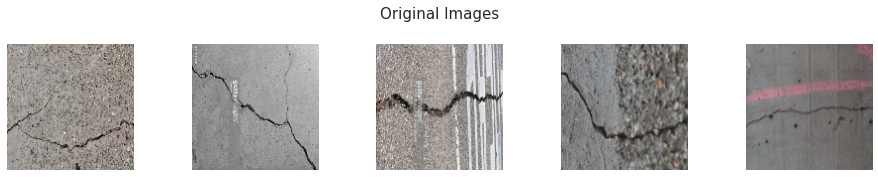

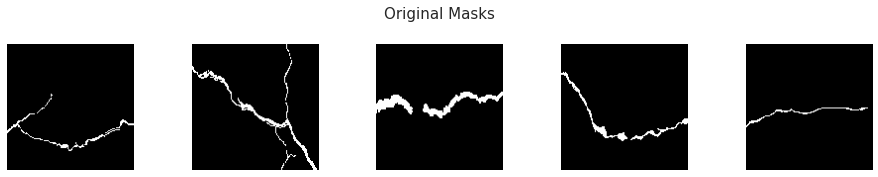

In [46]:
# Train generator samples (Un-augmented)
for i, j in train_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

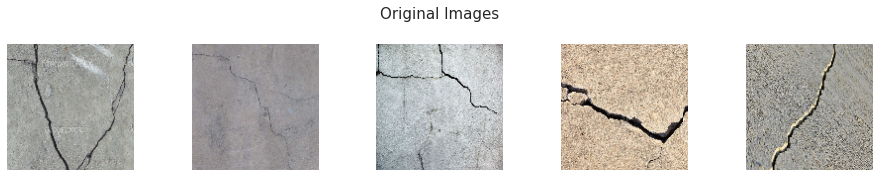

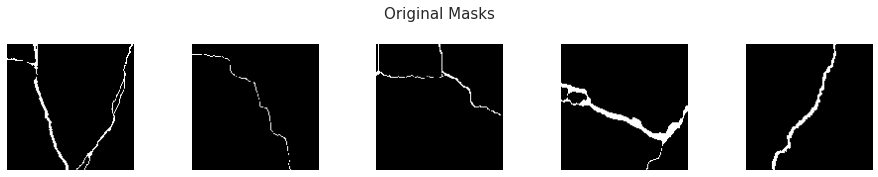

In [47]:
# Validation generator samples (Un-augmented)
for i, j in validation_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

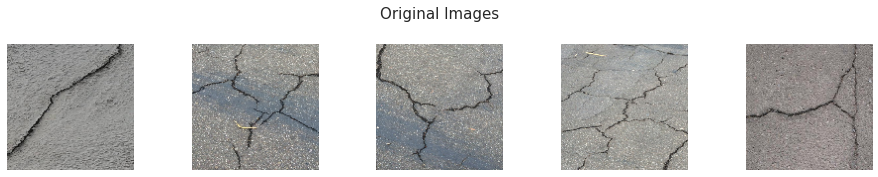

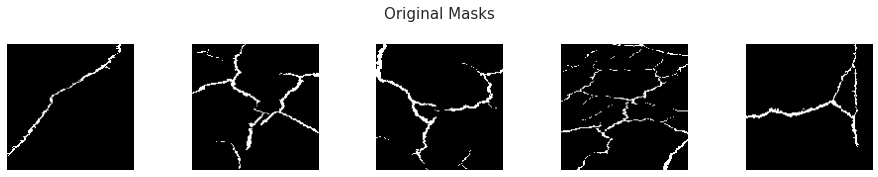

In [48]:
# test generator samples (Un-augmented)
for i, j in test_generator:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Original Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [49]:
tg = Generator(train_image_files, train_mask_files, batch_size, img_dim, augment = True)
vg = Generator(valid_image_files, valid_mask_files, batch_size, img_dim, augment = False)
testg=Generator(test_image_paths,test_mask_paths,batch_size,img_dim,augment=False)

In [50]:
for i, j in tg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [51]:
for i, j in vg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


In [52]:
for i, j in testg:
  break

print(i.shape)
print(j.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


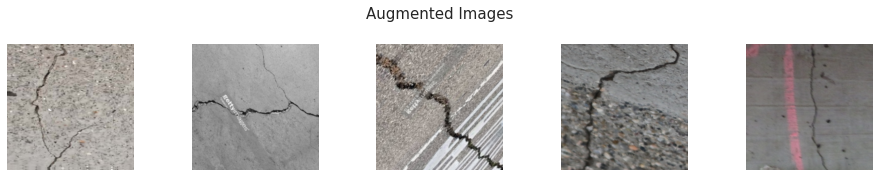

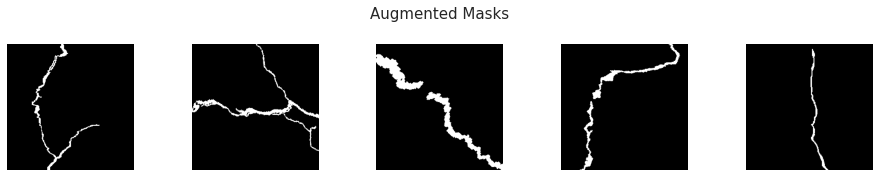

In [53]:
# Augmented train
for i, j in tg:
    break

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(13,2.5))
fig.suptitle('Augmented Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Model

In [54]:
import numpy as np
from tensorflow.keras.backend import int_shape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Add, BatchNormalization, Input, Activation, Concatenate
from tensorflow.keras.regularizers import l2

In [55]:
# BatchNormalization and Activation
def BN_Act(x, act = True):
    x = BatchNormalization()(x)
    if act == True:
        x = Activation("relu")(x)
    return x

In [56]:
# conv2d block
def conv2d_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    conv = BN_Act(x)
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(conv)
    return conv

In [57]:
# Fixed layer
def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding = padding, strides = strides)(x)
    conv = conv2d_block(conv, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    
    #skip
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([conv, shortcut])
    return output

In [58]:
#Residual Block
def residual_block(x, filters, kernel_size = (3, 3), padding = "same", strides = 1):
    res = conv2d_block(x, filters, kernel_size = kernel_size, padding = padding, strides = strides)
    res = conv2d_block(res, filters, kernel_size = kernel_size, padding = padding, strides = 1)
    
    shortcut = Conv2D(filters, kernel_size = (1, 1), padding = padding, strides = strides)(x)
    shortcut = BN_Act(shortcut, act = False) # No activation in skip connection
    
    output = Add()([shortcut, res])
    return output

In [59]:
#Upsample concatenation block
def upsample_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    c = Concatenate()([u, xskip])
    return c

In [60]:
# Complete model Architecture
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = Input((img_dim[0], img_dim[1], 3))
    
    ## Encoder/downsampling/contracting path
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides = 2)
    e3 = residual_block(e2, f[2], strides = 2)
    e4 = residual_block(e3, f[3], strides = 2)
    e5 = residual_block(e4, f[4], strides = 2)
    
    ## Bridge/Bottleneck
    b0 = conv2d_block(e5, f[4], strides = 1)
    b1 = conv2d_block(b0, f[4], strides = 1)
    
    ## Decoder/upsampling/expansive path
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = Conv2D(1, (1, 1), padding = "same", activation = "sigmoid")(d4)
    model = Model(inputs, outputs)
    return model

In [61]:
K.clear_session()
model = ResUNet()

2022-04-01 22:11:16.439548: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-01 22:11:16.439663: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 22:11:16.440057: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [62]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Loss Function


In [63]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou

# def bce_dice_loss(y_true, y_pred):

#     return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Learning Rate Schedular And other callbacks

In [64]:
def lr_schedule(epoch):
    lr =0.001
    if epoch >150:
        lr *=2**-1
    elif epoch >80:
        lr *=2**(-1)
    elif epoch >50:
        lr *=2**(-1)
    elif epoch >30:
        lr *=2**(-1)
    
    print('Learning rate: ', lr)
    return lr

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD

In [66]:

import time

start_time = time.time()

# Prepare callbacks for model saving and for learning rate adjustment.
lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-8)

callbacks = [lr_reducer, lr_scheduler]


### Compiling with adam and beyond

In [67]:
import tensorflow as tf
learning_rate = 0.0035
optimiser=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule(0),
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name="Adam"
)
model.compile(optimizer =optimiser , loss = dice_coef_loss, metrics = ['accuracy', IOU, dice_coef])

Learning rate:  0.001


In [68]:
# model.save('/content/drive/My Drive/Colab Notebooks/Adam_and_beyond.h5')

## Training

In [69]:
train_steps = len(train_image_files)//batch_size
valid_steps = len(valid_image_files)//batch_size

history = model.fit(
    tg, 
    steps_per_epoch=train_steps,
    initial_epoch = 0,
    epochs=100,
    validation_data = vg,    
    validation_steps = valid_steps,callbacks=callbacks)

2022-04-01 22:13:17.510613: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-01 22:13:17.530562: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3799900000 Hz


Epoch 1/100
Learning rate:  0.001
27/27 [==============================] - 196s 7s/step - loss: 0.6930 - accuracy: 0.8001 - IOU: 0.2422 - dice_coef: 0.3070 - val_loss: 1.0000 - val_accuracy: 0.9601 - val_IOU: 4.1994e-12 - val_dice_coef: 4.2034e-05
Epoch 2/100
Learning rate:  0.001
27/27 [==============================] - 196s 7s/step - loss: 0.3007 - accuracy: 0.9804 - IOU: 0.5481 - dice_coef: 0.6993 - val_loss: 0.9283 - val_accuracy: 0.5345 - val_IOU: 0.0366 - val_dice_coef: 0.0717
Epoch 3/100
Learning rate:  0.001
27/27 [==============================] - 190s 7s/step - loss: 0.2588 - accuracy: 0.9818 - IOU: 0.5953 - dice_coef: 0.7412 - val_loss: 0.9476 - val_accuracy: 0.8951 - val_IOU: 0.0268 - val_dice_coef: 0.0524
Epoch 4/100
Learning rate:  0.001
27/27 [==============================] - 193s 7s/step - loss: 0.2403 - accuracy: 0.9843 - IOU: 0.6188 - dice_coef: 0.7597 - val_loss: 0.9999 - val_accuracy: 0.9601 - val_IOU: 4.1994e-12 - val_dice_coef: 1.2708e-04
Epoch 5/100
Learning rat

Epoch 35/100
Learning rate:  0.0005
27/27 [==============================] - 182s 7s/step - loss: 0.1570 - accuracy: 0.9898 - IOU: 0.7313 - dice_coef: 0.8430 - val_loss: 0.1642 - val_accuracy: 0.9868 - val_IOU: 0.7191 - val_dice_coef: 0.8358
Epoch 36/100
Learning rate:  0.0005
27/27 [==============================] - 187s 7s/step - loss: 0.1594 - accuracy: 0.9882 - IOU: 0.7287 - dice_coef: 0.8406 - val_loss: 0.1554 - val_accuracy: 0.9878 - val_IOU: 0.7321 - val_dice_coef: 0.8446
Epoch 37/100
Learning rate:  0.0005
27/27 [==============================] - 187s 7s/step - loss: 0.1719 - accuracy: 0.9879 - IOU: 0.7108 - dice_coef: 0.8281 - val_loss: 0.1572 - val_accuracy: 0.9877 - val_IOU: 0.7292 - val_dice_coef: 0.8428
Epoch 38/100
Learning rate:  0.0005
27/27 [==============================] - 184s 7s/step - loss: 0.1533 - accuracy: 0.9893 - IOU: 0.7374 - dice_coef: 0.8467 - val_loss: 0.1528 - val_accuracy: 0.9878 - val_IOU: 0.7366 - val_dice_coef: 0.8472
Epoch 39/100
Learning rate:  0.0

Epoch 69/100
Learning rate:  0.0005
27/27 [==============================] - 189s 7s/step - loss: 0.1546 - accuracy: 0.9894 - IOU: 0.7346 - dice_coef: 0.8454 - val_loss: 0.1630 - val_accuracy: 0.9872 - val_IOU: 0.7215 - val_dice_coef: 0.8370
Epoch 70/100
Learning rate:  0.0005
27/27 [==============================] - 188s 7s/step - loss: 0.1543 - accuracy: 0.9892 - IOU: 0.7347 - dice_coef: 0.8457 - val_loss: 0.1580 - val_accuracy: 0.9872 - val_IOU: 0.7282 - val_dice_coef: 0.8420
Epoch 71/100
Learning rate:  0.0005
27/27 [==============================] - 187s 7s/step - loss: 0.1814 - accuracy: 0.9882 - IOU: 0.6982 - dice_coef: 0.8186 - val_loss: 0.1538 - val_accuracy: 0.9880 - val_IOU: 0.7342 - val_dice_coef: 0.8462
Epoch 72/100
Learning rate:  0.0005
27/27 [==============================] - 190s 7s/step - loss: 0.1527 - accuracy: 0.9893 - IOU: 0.7375 - dice_coef: 0.8473 - val_loss: 0.1537 - val_accuracy: 0.9877 - val_IOU: 0.7350 - val_dice_coef: 0.8463
Epoch 73/100
Learning rate:  0.0

In [70]:
# save model
model.save('deepcrack.h5')
print('Model Saved!')

Model Saved!


In [71]:
# saving and loading the model weights
 
# save model
model.save_weights('deepcrack_weights')
print('Model Saved!')
 
# load model
# savedModel = model.load_weights('gfgModelWeights')
# print('Model Loaded!')

Model Saved!


In [72]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

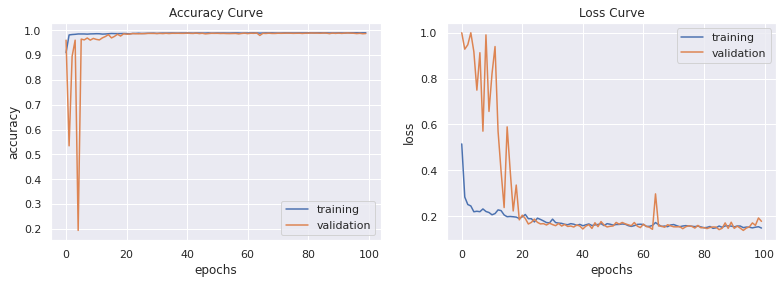

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()


axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()



axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [74]:
train_dice = history.history['dice_coef']
valid_dice = history.history['val_dice_coef']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

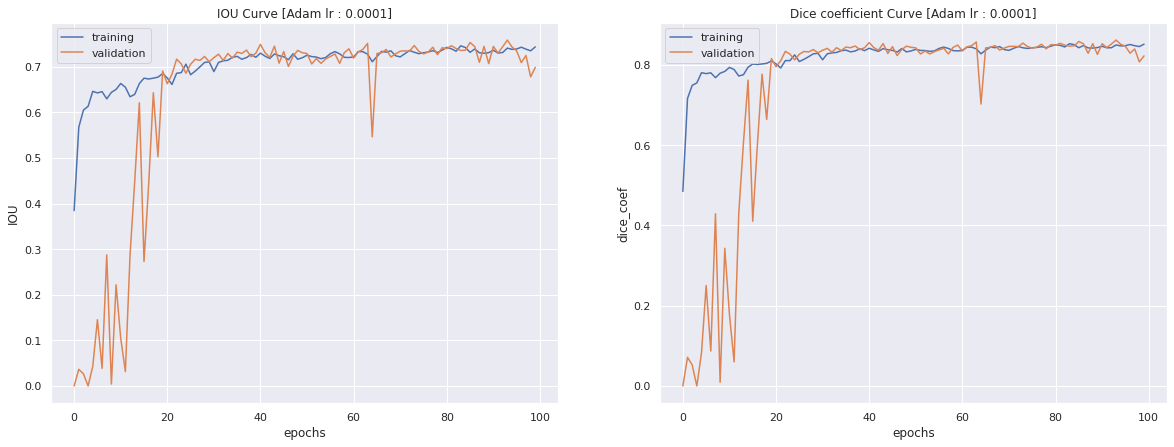

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve [Adam lr : 0.0001]')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve [Adam lr : 0.0001]')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()

## Testing

In [76]:
test_generator = Generator(test_image_paths, test_mask_paths,237, img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

In [77]:
report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

Accuracy: 0.9841

Precision: 0.9504

Recall: 0.7080

F1-Score: 0.8115

Sensitivity: 0.7080

Specificity: 0.9981

AUC: 0.9009

IOU: 0.6827

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.99      1.00      0.99  14780073
        True       0.95      0.71      0.81    751959

    accuracy                           0.98  15532032
   macro avg       0.97      0.85      0.90  15532032
weighted avg       0.98      0.98      0.98  15532032



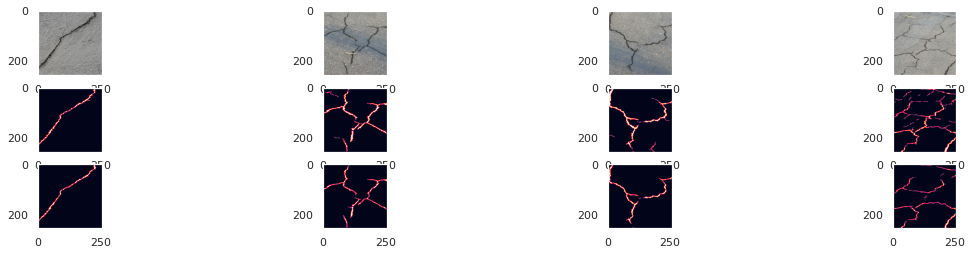

In [80]:
test_generator = Generator(test_image_paths, test_mask_paths,237, img_dim)

for x_test, y_test in test_generator:
  break

y_pred = model.predict(x_test)

plt.figure(figsize=(40, 4))
for i in range(4):
    # display image
    plt.grid(False)
    ax = plt.subplot(3, 8, i + 1)
    plt.imshow(x_test[i])
    # display original label
    plt.grid(False)
    ax = plt.subplot(3, 8, 8+i + 1)
    plt.imshow(y_test[i])
    
    # display reconstructed (after noise removed) image
    plt.grid(False)
    ax = plt.subplot(3, 8, 16 +i+ 1)
    plt.imshow(y_pred[i])

plt.grid(False)
plt.show()

In [81]:
print(x_test.shape)
print(y_test.shape)
print(y_pred.shape)

(237, 256, 256, 3)
(237, 256, 256, 1)
(237, 256, 256, 1)


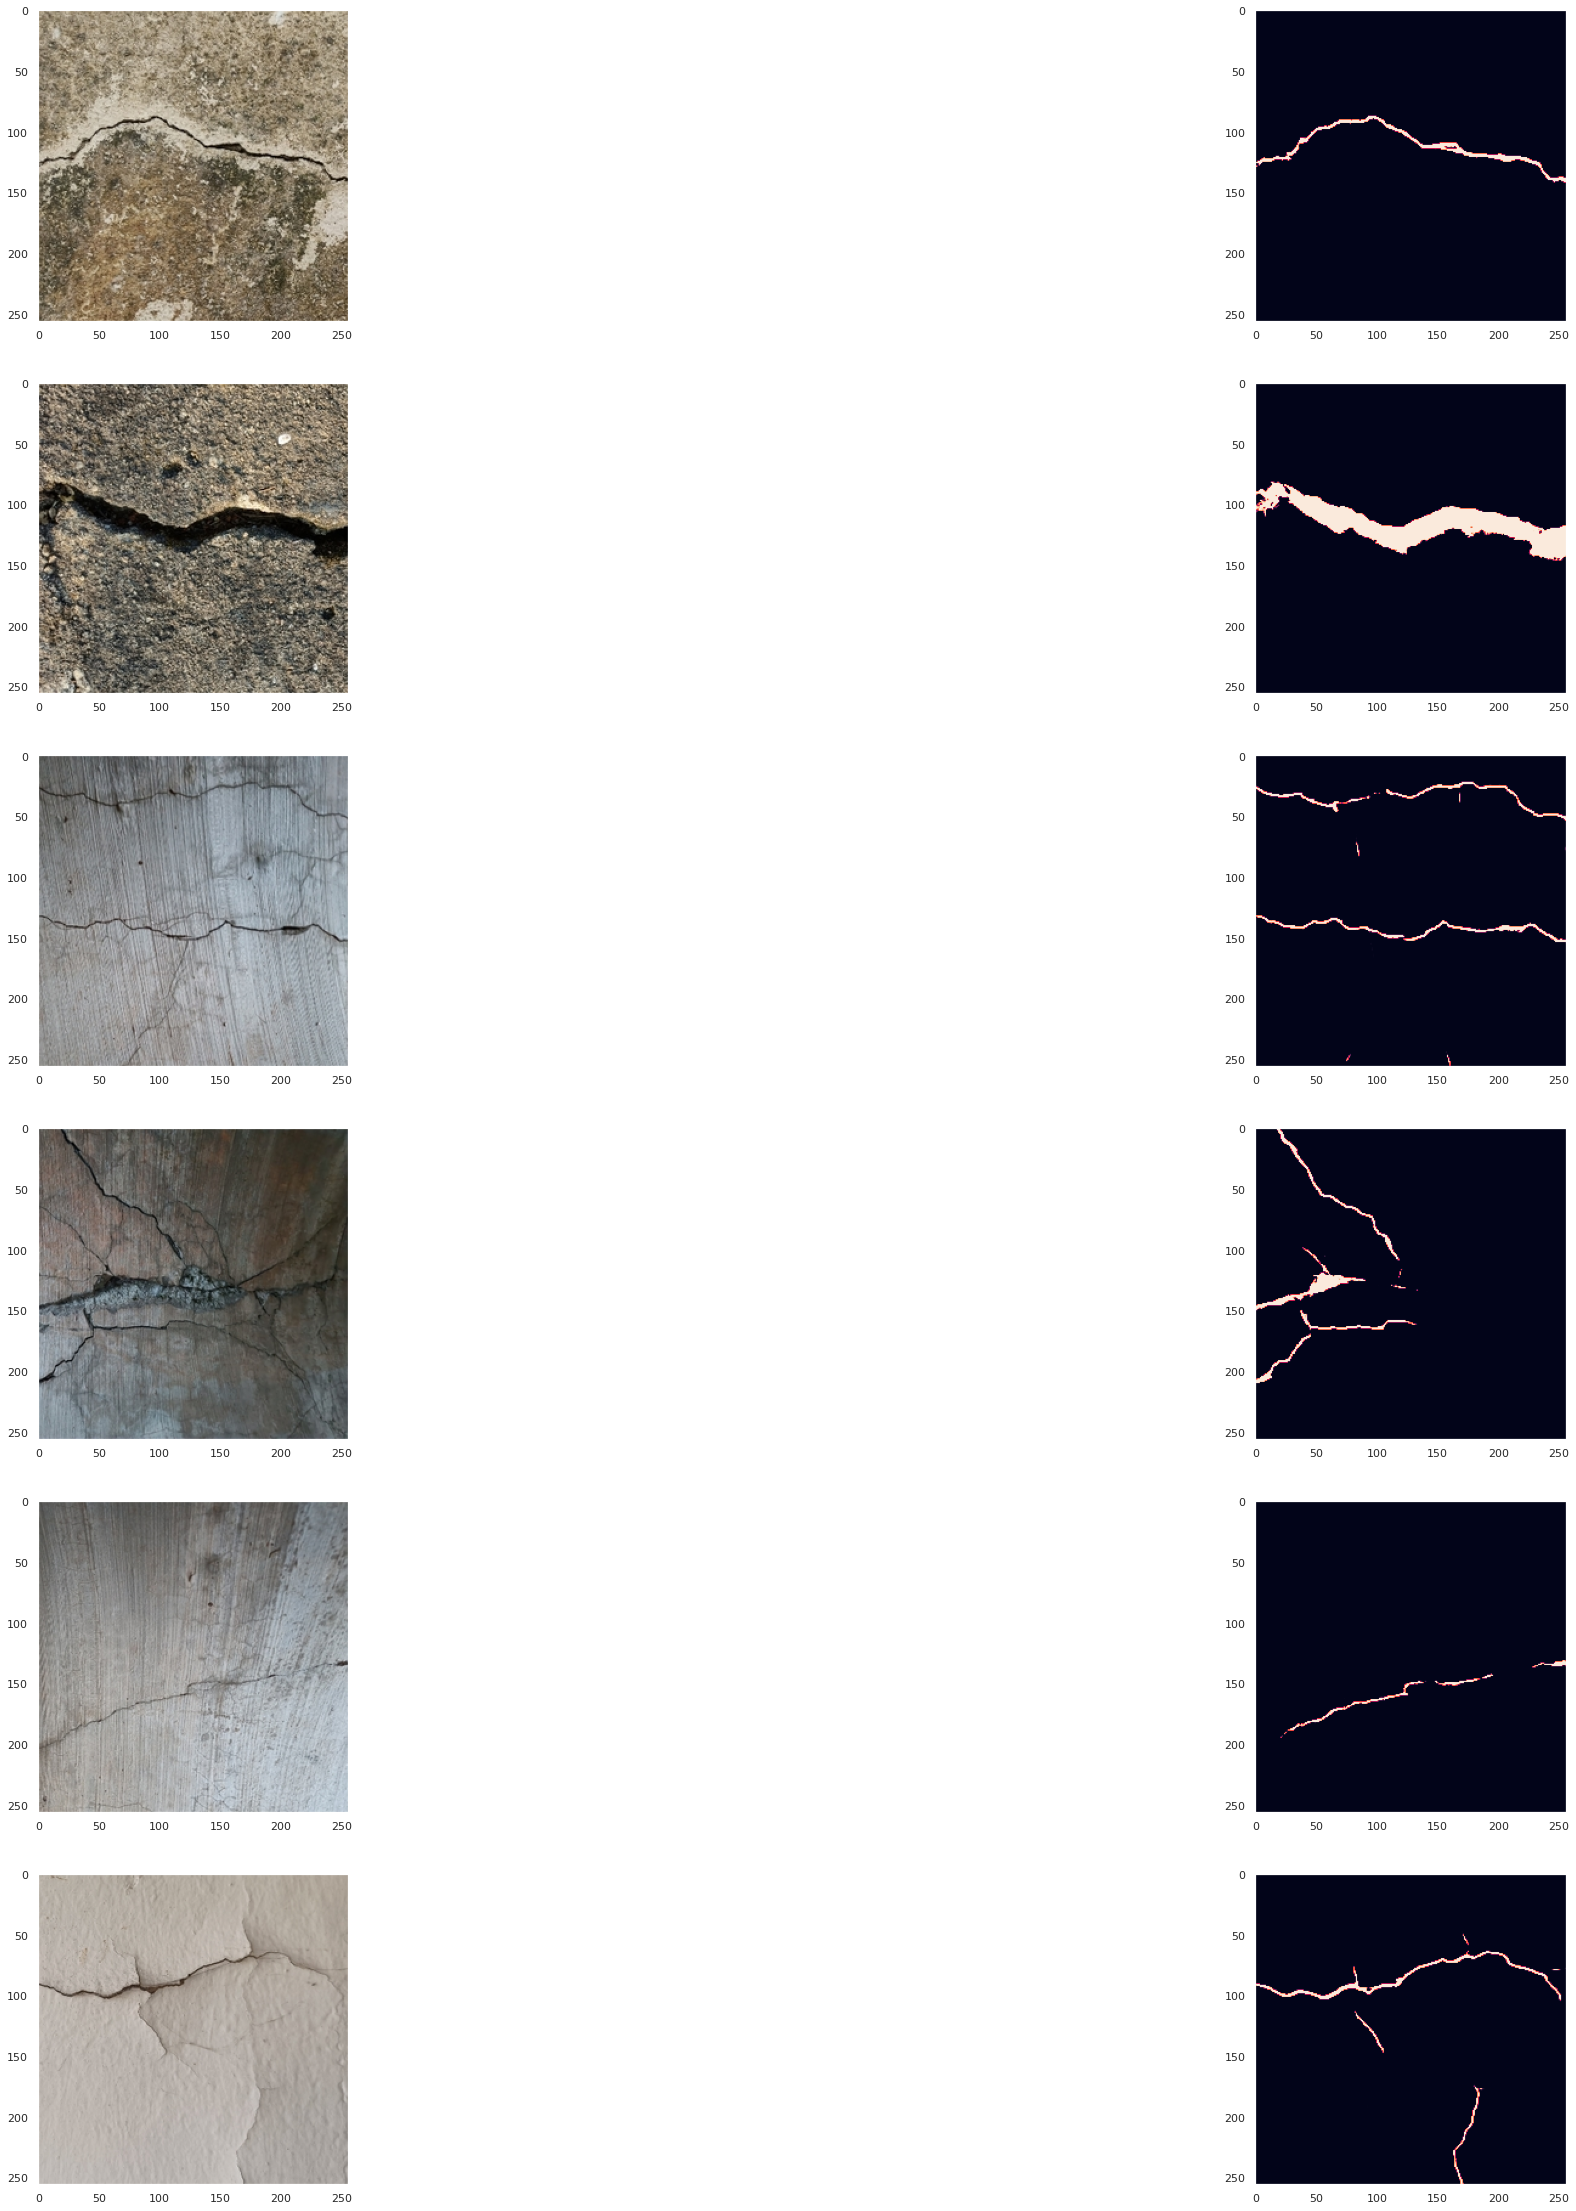

In [82]:
# campus_image_dir = r'/home/ubuntu/Desktop/NNDL Project/campus_crack'
path = r'/home/ubuntu/Downloads/pipe_images_256'
pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

pipe = Generator(pipe_image_paths, pipe_image_paths, batch_size, img_dim, augment = False)
for p_test, y_test in pipe:
    break
#print(images.shape)

pipe_pred = model.predict(p_test)

n=len(p_test)

plt.figure(figsize=(40, 40))
for i in range(n):
    # display image
    plt.grid(False)
    plt.subplot(n,2,2*i+1)
    plt.imshow(p_test[i])
    
    # display reconstructed (after noise removed) image
    plt.grid(False)
    plt.subplot(n, 2,  2*(i+1))
    plt.imshow(pipe_pred[i])

plt.grid(False)
plt.show()

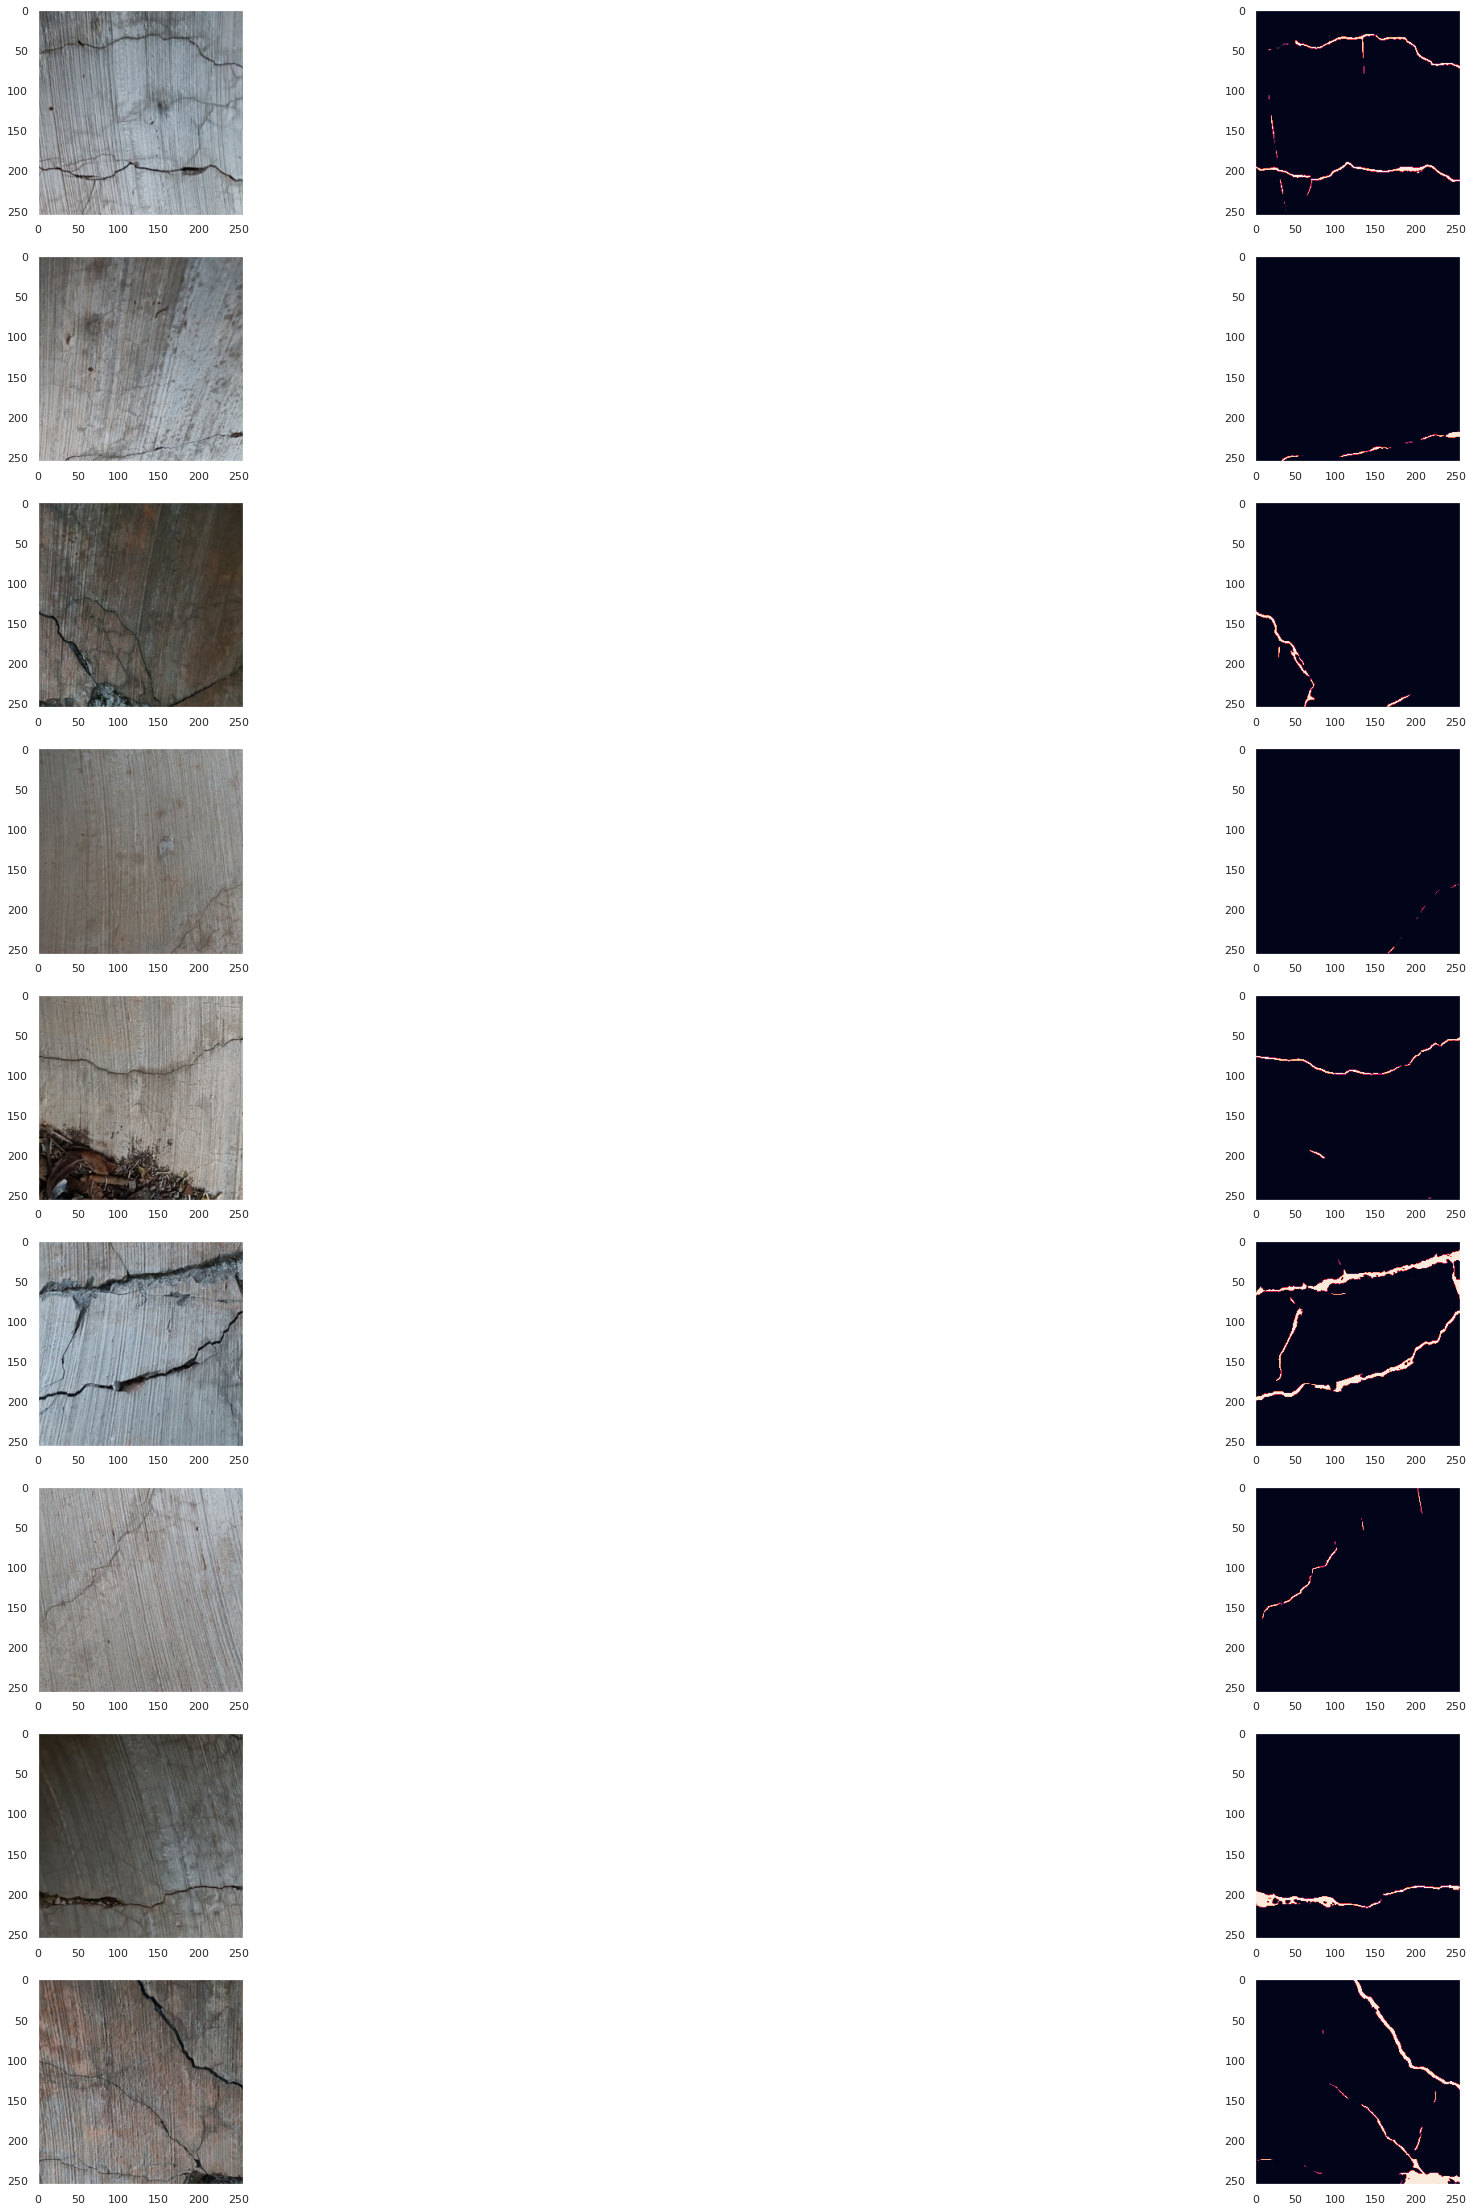

In [83]:
path = r'/home/ubuntu/Desktop/NNDL Project/PIPE NEW 256'
pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

pipe = Generator(pipe_image_paths, pipe_image_paths, batch_size, img_dim, augment = False)
for p_test, y_test in pipe:
    break
#print(images.shape)

pipe_pred = model.predict(p_test)

n=len(p_test)
# plt.subplot(9,3,1)
# plt.imshow(p_test[3])
# plt.subplot(9,3,2)
# plt.imshow(pipe_pred[3])
plt.figure(figsize=(40, 40))
for i in range(n):
    # display image
    plt.grid(False)
    plt.subplot(n,2,2*i+1)
    plt.imshow(p_test[i])
#     # display original label
#     ax = plt.subplot(3, 8, 8+i + 1)
#     plt.imshow(y_test[i])
    
    # display reconstructed (after noise removed) image
    plt.grid(False)
    plt.subplot(n, 2,  2*(i+1))
    plt.imshow(pipe_pred[i])

plt.grid(False)
plt.show()

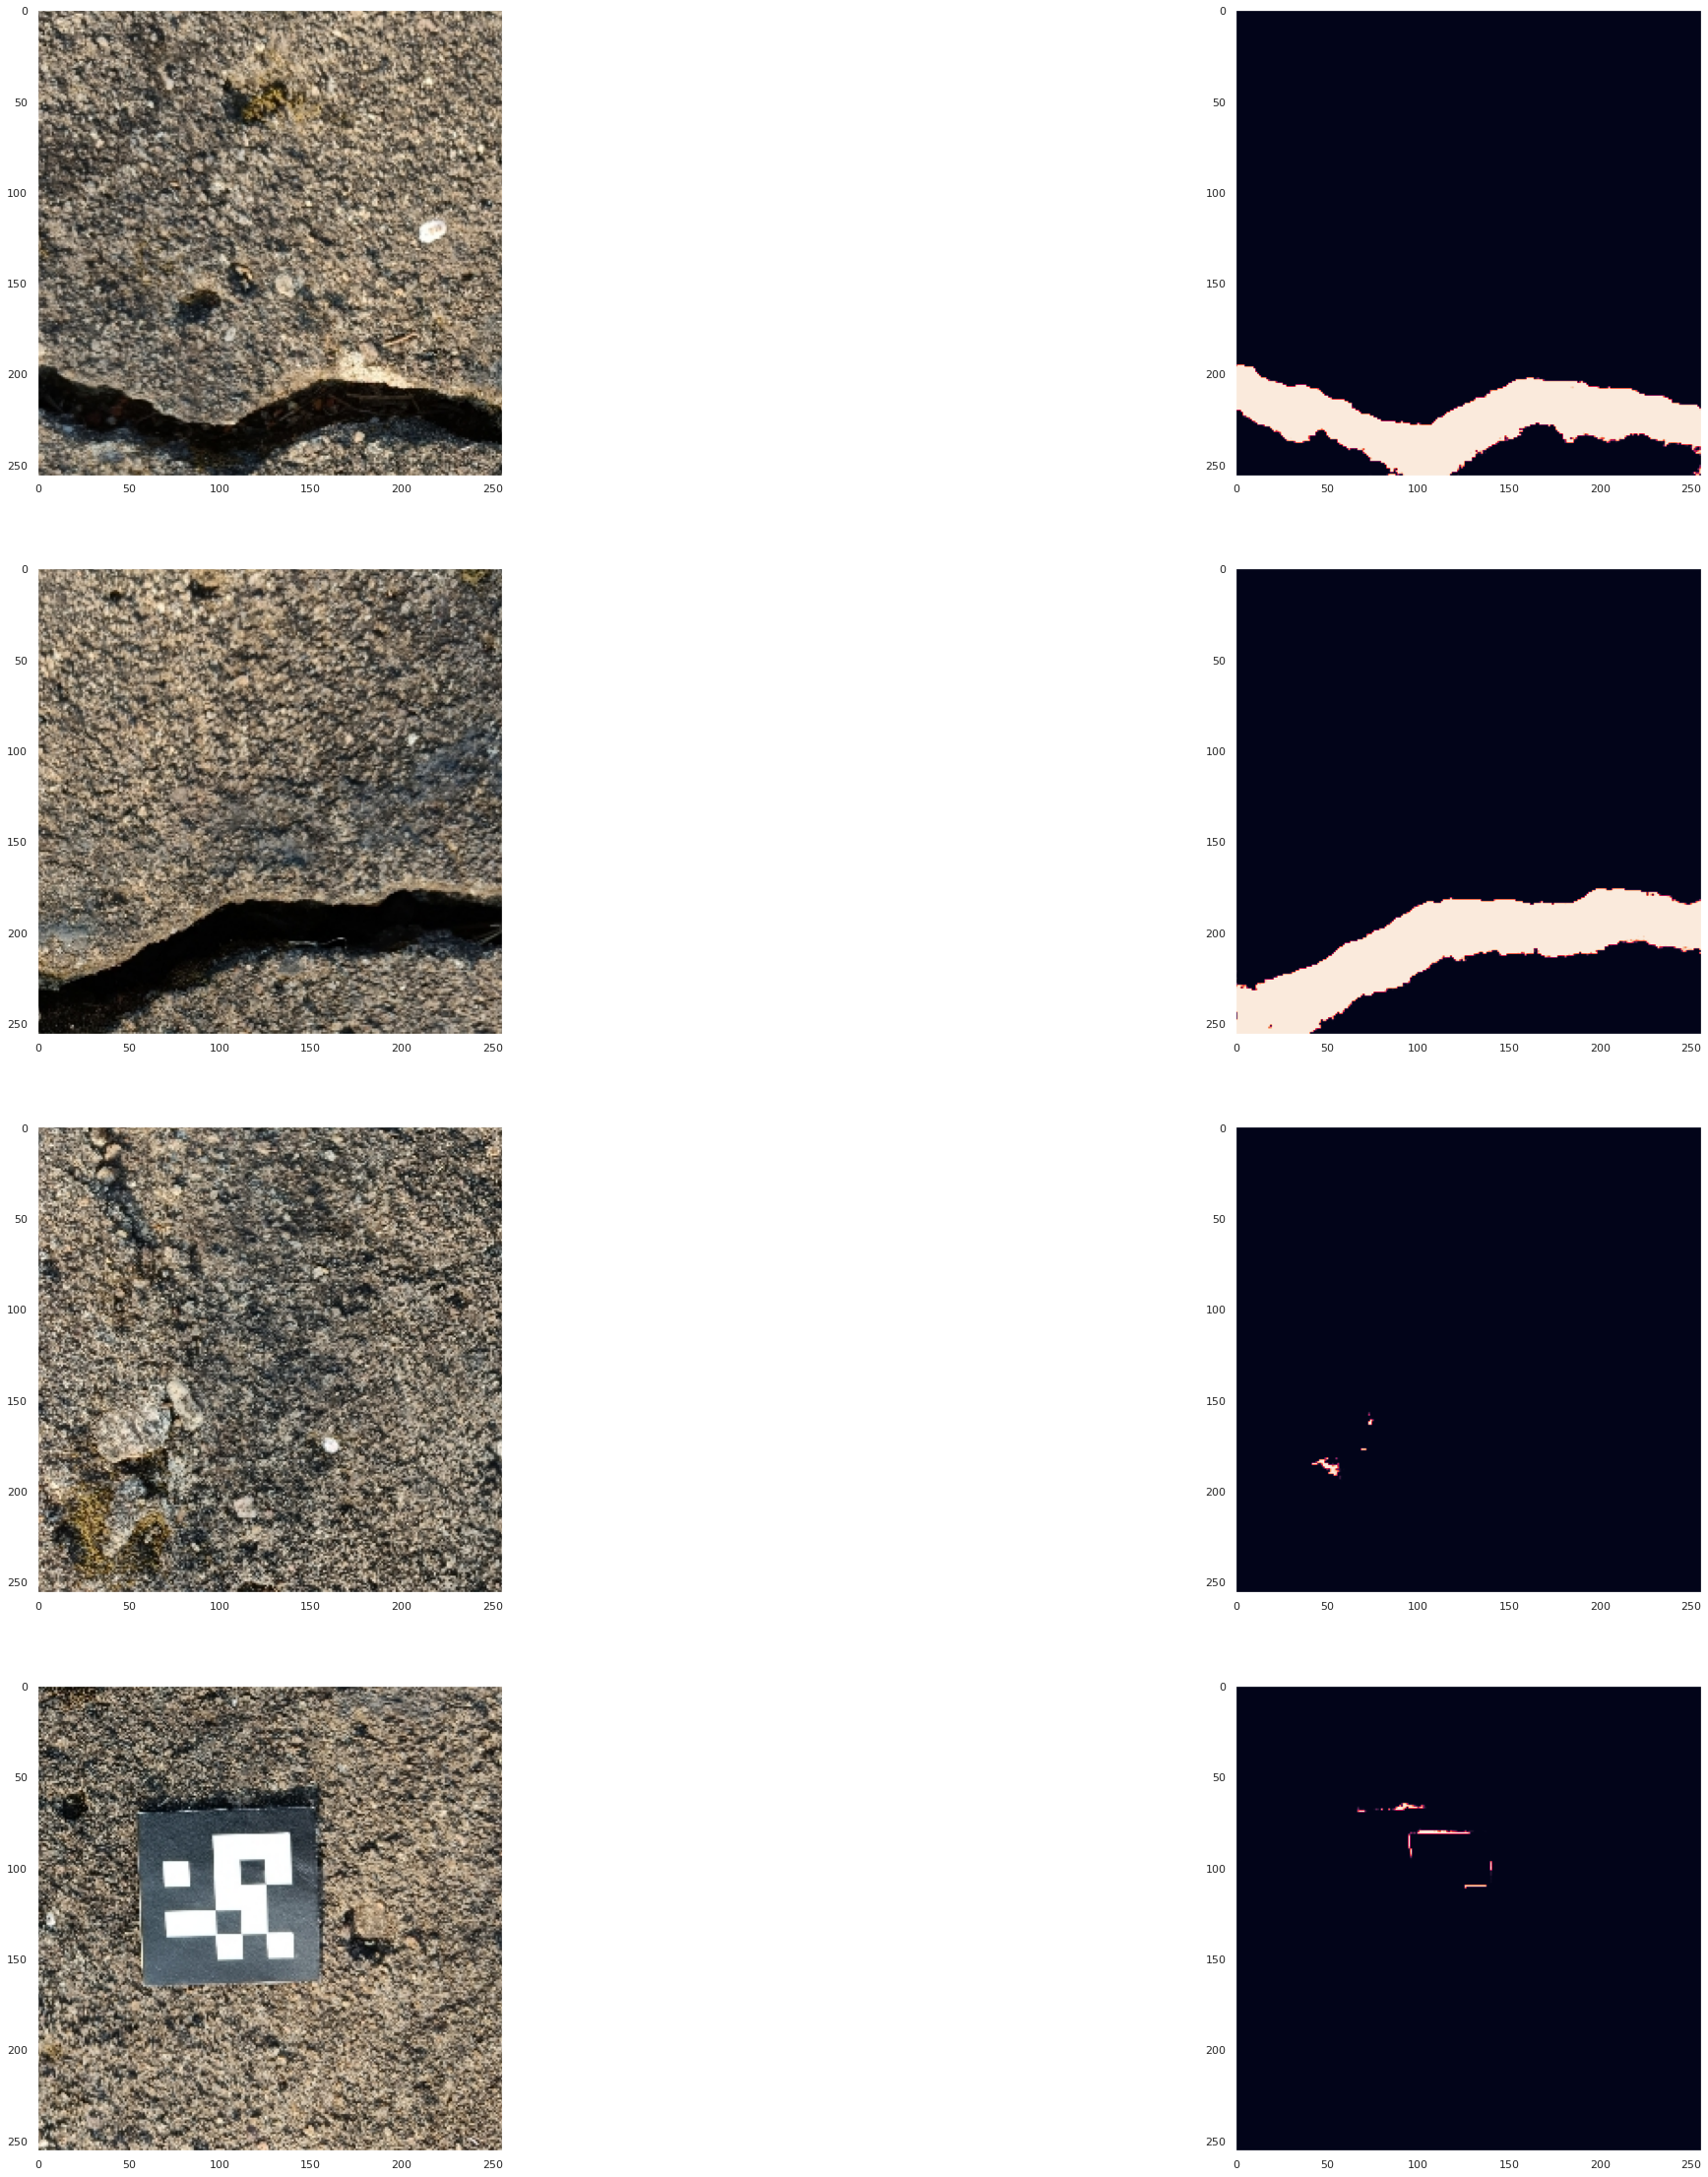

In [84]:
path = r'/home/ubuntu/Desktop/NNDL Project/PAVEMENT NEW 256'
pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

pipe = Generator(pipe_image_paths, pipe_image_paths, batch_size, img_dim, augment = False)
for p_test, y_test in pipe:
    break
#print(images.shape)

pipe_pred = model.predict(p_test)

n=len(p_test)
# plt.subplot(9,3,1)
# plt.imshow(p_test[3])
# plt.subplot(9,3,2)
# plt.imshow(pipe_pred[3])
plt.figure(figsize=(40, 40))
for i in range(n):
    # display image
    plt.grid(False)
    plt.subplot(n,2,2*i+1)
    plt.imshow(p_test[i])
#     # display original label
#     ax = plt.subplot(3, 8, 8+i + 1)
#     plt.imshow(y_test[i])
    
    # display reconstructed (after noise removed) image
    plt.grid(False)
    plt.subplot(n, 2,  2*(i+1))
    plt.imshow(pipe_pred[i])

plt.grid(False)
plt.show()

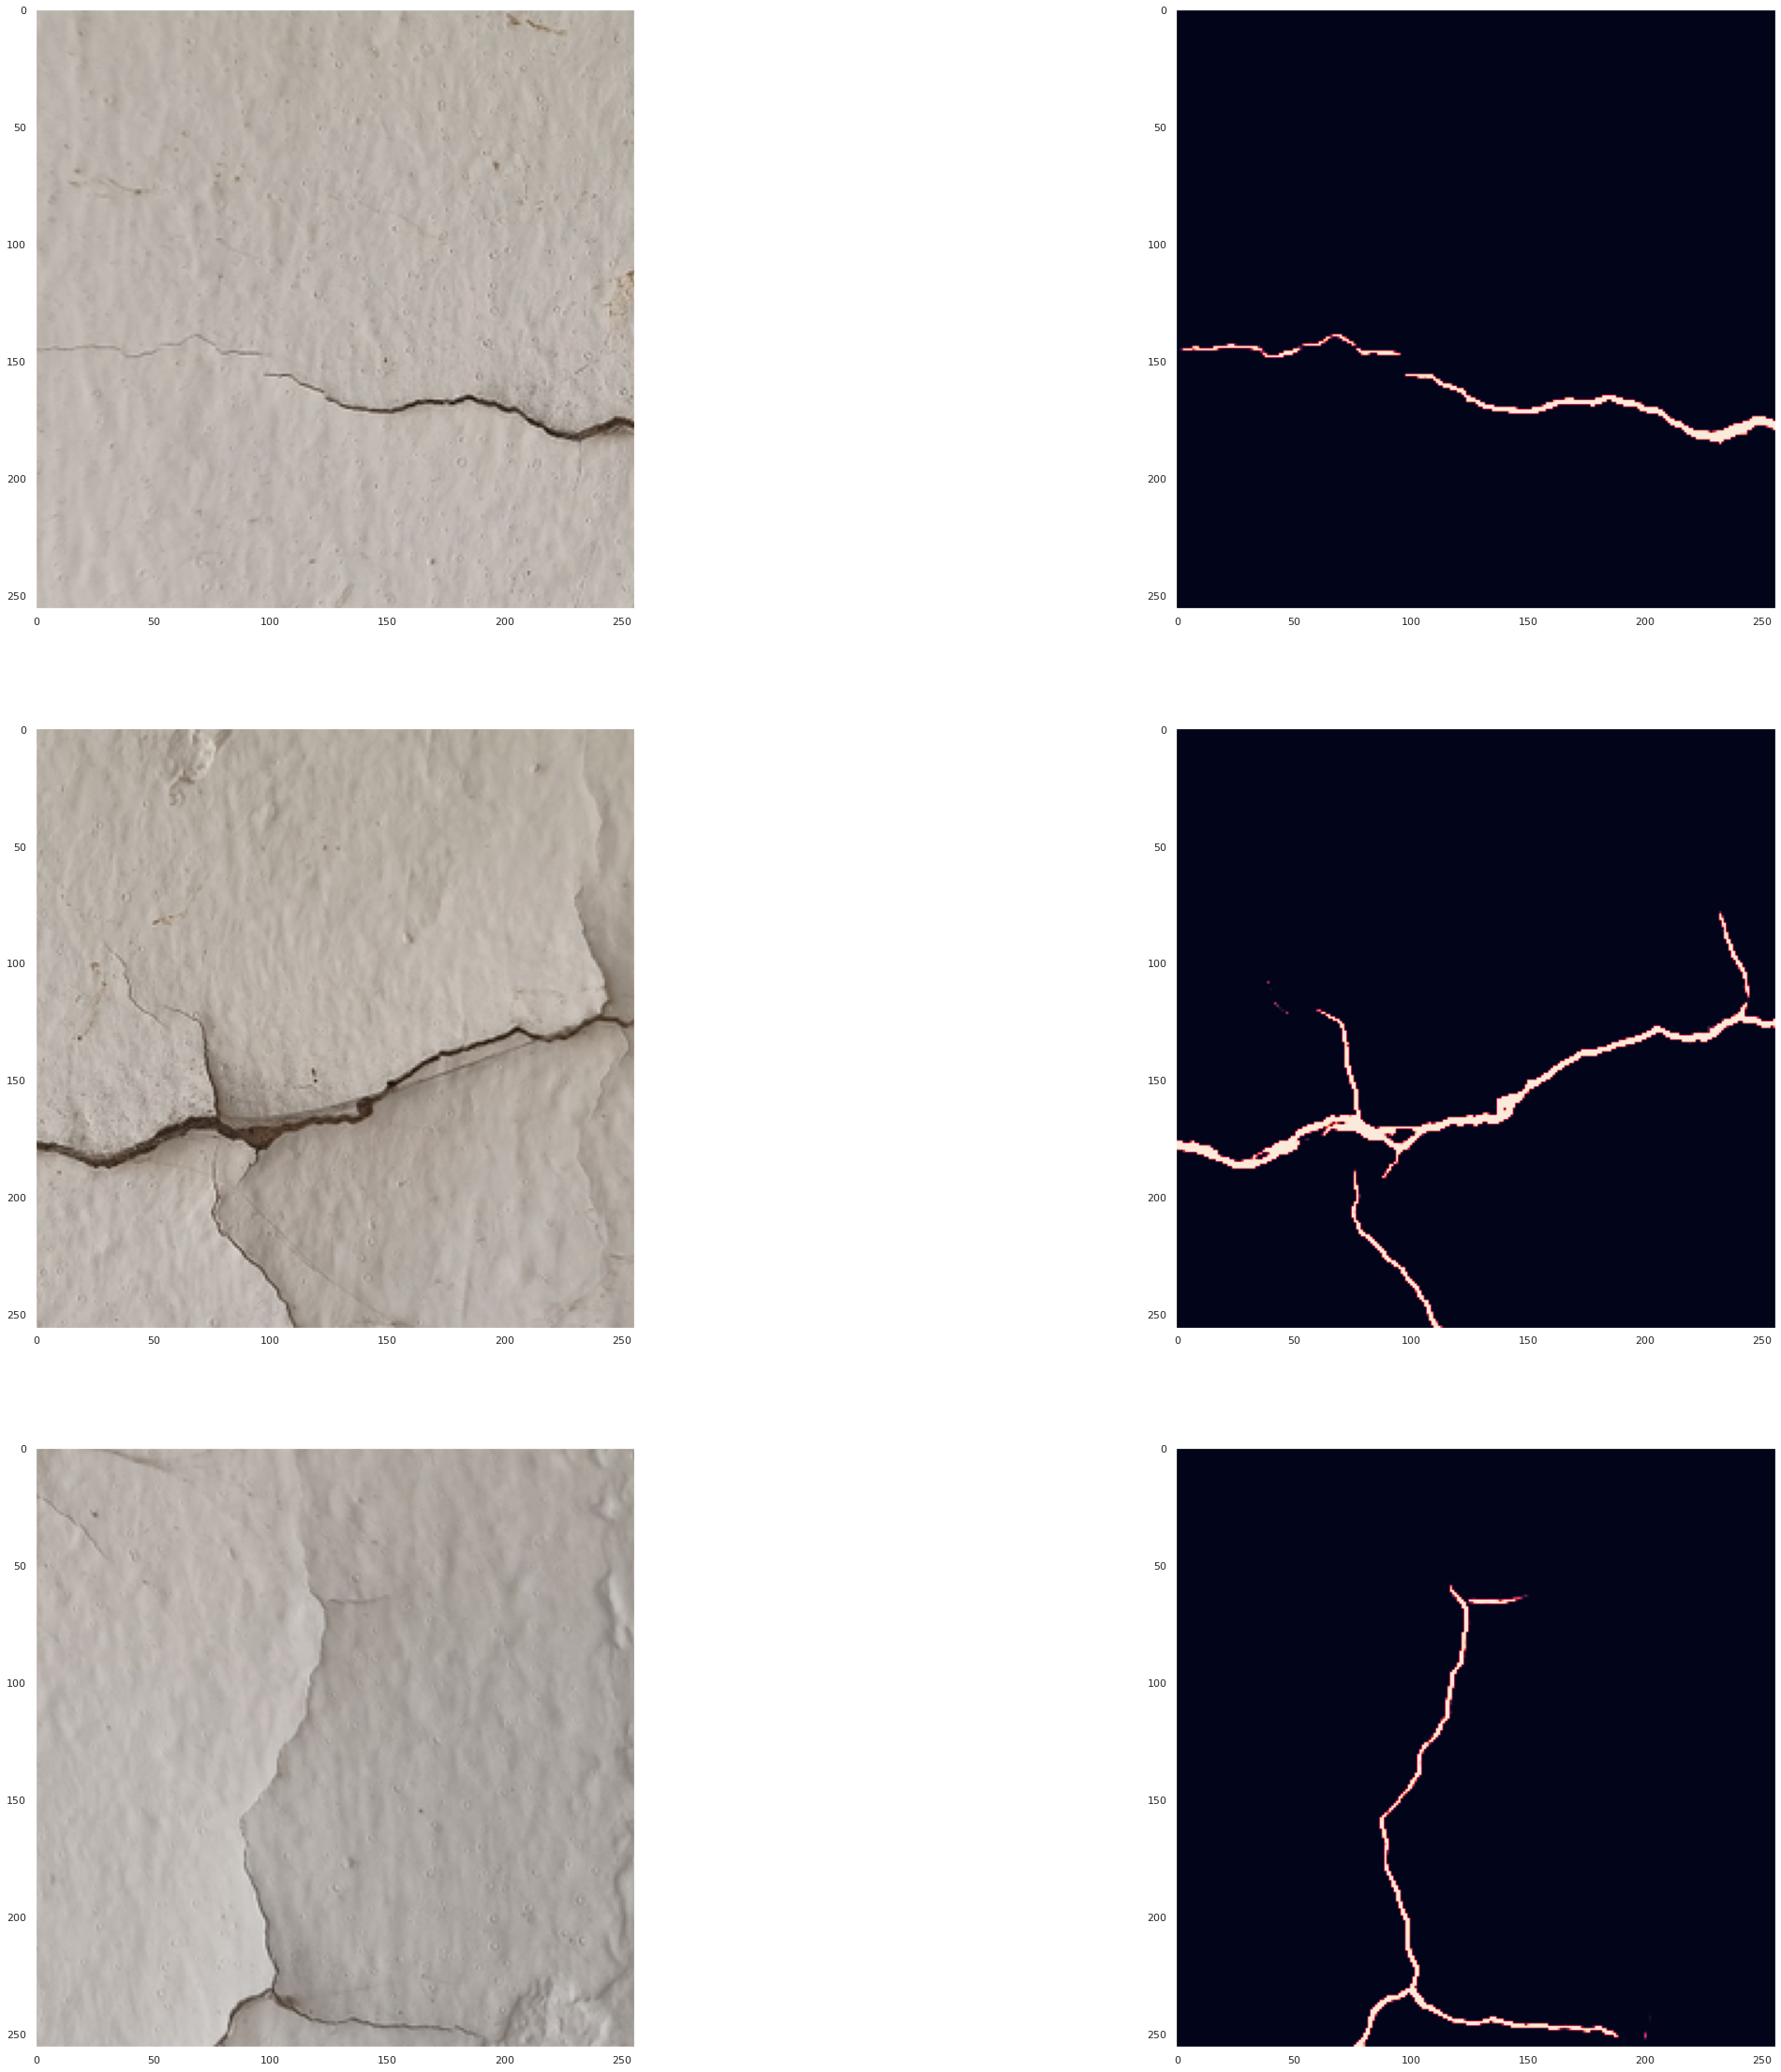

In [85]:
path = r'/home/ubuntu/Desktop/NNDL Project/WALL NEW 256'
pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

pipe = Generator(pipe_image_paths, pipe_image_paths, batch_size, img_dim, augment = False)
for p_test, y_test in pipe:
    break
#print(images.shape)

pipe_pred = model.predict(p_test)

n=len(p_test)
# plt.subplot(9,3,1)
# plt.imshow(p_test[3])
# plt.subplot(9,3,2)
# plt.imshow(pipe_pred[3])
plt.figure(figsize=(40, 40))
for i in range(n):
    # display image
    plt.grid(False)
    plt.subplot(n,2,2*i+1)
    plt.imshow(p_test[i])
#     # display original label
#     ax = plt.subplot(3, 8, 8+i + 1)
#     plt.imshow(y_test[i])
    
    # display reconstructed (after noise removed) image
    plt.grid(False)
    plt.subplot(n, 2,  2*(i+1))
    plt.imshow(pipe_pred[i])

plt.grid(False)
plt.show()

(9, 256, 256, 3)
(9, 256, 256, 3, 1)
(9, 256, 256, 3)
(9, 256, 256, 1)
(589824,)
(589824,)
(589824,)
(589824,)
Accuracy: 0.9474

Precision: 0.9472

Recall: 0.2386

F1-Score: 0.3812

Sensitivity: 0.2386

Specificity: 0.9990

AUC: 0.4934

IOU: 0.2355

-------------------------------------------------- 

              precision    recall  f1-score   support

       False       0.95      1.00      0.97    549788
        True       0.95      0.24      0.38     40036

    accuracy                           0.95    589824
   macro avg       0.95      0.62      0.68    589824
weighted avg       0.95      0.95      0.93    589824



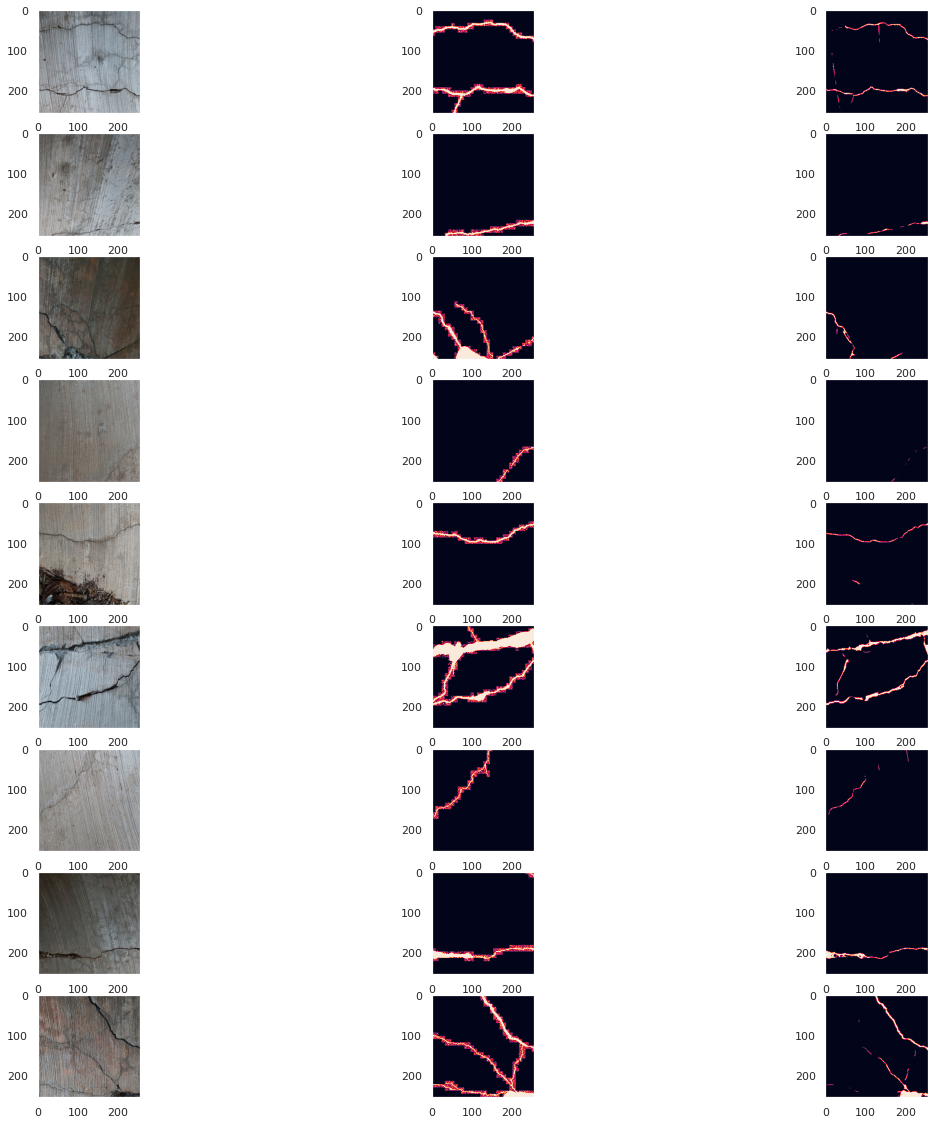

In [86]:
path = r'/home/ubuntu/Desktop/NNDL Project/PIPE NEW 256'
pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

test_lab_path = r'/home/ubuntu/Desktop/NNDL Project/Pipe GT'
pipe_lab_paths = sorted([os.path.join(test_lab_path, fname) for fname in os.listdir(test_lab_path) if fname.endswith(".jpg") and not fname.startswith(".")])


pipe = Generator(pipe_image_paths, pipe_lab_paths, 9, img_dim, augment = False)
for p_test, y_test in pipe:
    break
print(p_test.shape)
print(y_test.shape)
y_test = y_test.reshape(y_test.shape[0],y_test.shape[1],y_test.shape[2],y_test.shape[3])
print(y_test.shape)
y_test = np.expand_dims(y_test[:,:,:,0], axis = -1)
print(y_test.shape)

y_pred = model.predict(p_test)

yy_true = (y_test>0.5).flatten()
yy_pred = (y_pred>0.5).flatten()

print(yy_true.shape)
print(yy_pred.shape)

print((y_test.flatten().shape))
print((y_pred.flatten().shape))

report = classification_report(yy_true, yy_pred, output_dict=True)

Accuracy = accuracy_score(yy_true, yy_pred)

Precision = report['True']['precision']
Recall = report['True']['recall']
F1_score = report['True']['f1-score']

Sensitivity = Recall
Specificity = report['False']['recall']

AUC = roc_auc_score(y_test.flatten(), y_pred.flatten())

IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)

print("Accuracy: {0:.4f}\n".format(Accuracy))
print("Precision: {0:.4f}\n".format(Precision))
print("Recall: {0:.4f}\n".format(Recall))
print("F1-Score: {0:.4f}\n".format(F1_score))
print("Sensitivity: {0:.4f}\n".format(Sensitivity))
print("Specificity: {0:.4f}\n".format(Specificity))
print("AUC: {0:.4f}\n".format(AUC))
print("IOU: {0:.4f}\n".format(IOU))
print('-'*50,'\n')
print(classification_report(yy_true, yy_pred))

n=len(p_test)

plt.figure(figsize=(20, 20))

for i in range(n):
    # display image
    plt.grid(False)
    plt.subplot(n,3,3*i+1)
    plt.imshow(p_test[i])
    
    plt.grid(False)
    plt.subplot(n,3,3*i+2)
    plt.imshow(y_test[i])
    
    # display reconstructed (after noise removed) image
    plt.grid(False)
    plt.subplot(n, 3,  3*(i+1))
    plt.imshow(y_pred[i])

plt.grid(False)    
plt.show()

In [87]:
# # path = r'/home/ubuntu/Desktop/NNDL Project/WALL NEW 256'
# # path = r'/home/ubuntu/Desktop/NNDL Project/PAVEMENT NEW 256'
# path = r'/home/ubuntu/Desktop/NNDL Project/PIPE NEW 256'
# pipe_image_paths = sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".jpg") and not fname.startswith(".")])

# pipe = Generator(pipe_image_paths, pipe_image_paths, batch_size, img_dim, augment = False)
# for p_test, y_test in pipe:
#     break
# #print(images.shape)

# pipe_pred = model.predict(p_test)

# n=len(p_test)
# # plt.subplot(9,3,1)
# # plt.imshow(p_test[3])
# # plt.subplot(9,3,2)
# plt.imshow(pipe_pred[8])
# # plt.figure(figsize=(40, 40))
# # for i in range(n):
# #     # display image
# #     plt.subplot(n,2,2*i+1)
# #     plt.imshow(p_test[i])
# # #     # display original label
# # #     ax = plt.subplot(3, 8, 8+i + 1)
# # #     plt.imshow(y_test[i])
    
# #     # display reconstructed (after noise removed) image
# #     plt.subplot(n, 2,  2*(i+1))
# #     plt.imshow(pipe_pred[i])

# plt.show()